# Necessary imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import random
import cv2
import os
import splitfolders
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import applications
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tifffile import imsave
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

# Dataloader

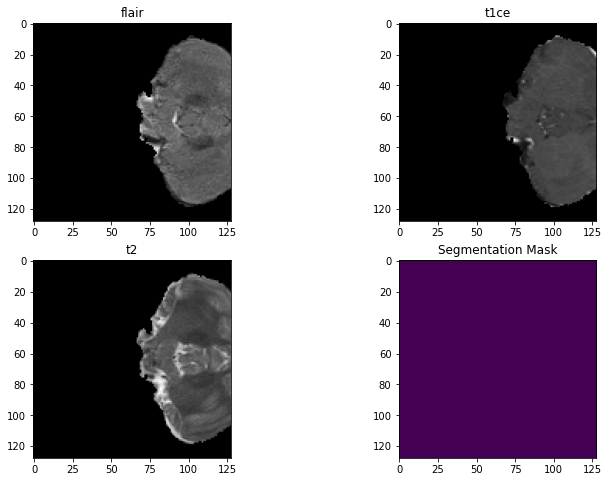

In [18]:
def load_img(img_dir, images_list):
    images=[]
    for i, image_name in enumerate(images_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, images_list, mask_dir, mask_list, batch_size):

    L = len(images_list)
  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, images_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


#Test the generator
training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

batch_size = 2

training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

img, msk = training_images_datagenerator.__next__()


num = random.randint(0,img.shape[0]-1)
test_img=img[num]
test_seg_mask=msk[num]
test_seg_mask=np.argmax(test_seg_mask, axis=3)

n_slice=random.randint(0, test_seg_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('t2')
plt.subplot(224)
plt.imshow(test_seg_mask[:,:,n_slice])
plt.title('Segmentation Mask')
plt.show()

# Transfer Learning

In [19]:
from classification_models_3D.tfkeras import Classifiers

resnet50, preprocess_input = Classifiers.get('resnet50')
model = resnet50(input_shape=(128, 128, 128, 3),weights='imagenet')

In [20]:
kernel_initializer =  'he_uniform'
model1 = Sequential()
model1.add(Model(model.input, model.output))
model1.add(Conv3DTranspose(1024, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(1024, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(4, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(4, (1, 1, 1), activation='softmax'))

In [21]:
for layer in model1.layers[:-10]:
    layer.trainable = False
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 4, 4, 4, 2048)     46237001  
                                                                 
 conv3d_transpose_5 (Conv3DT  (None, 8, 8, 8, 1024)    16778240  
 ranspose)                                                       
                                                                 
 conv3d_501 (Conv3D)         (None, 8, 8, 8, 1024)     28312576  
                                                                 
 conv3d_transpose_6 (Conv3DT  (None, 16, 16, 16, 256)  2097408   
 ranspose)                                                       
                                                                 
 conv3d_502 (Conv3D)         (None, 16, 16, 16, 256)   1769728   
                                                                 
 conv3d_transpose_7 (Conv3DT  (None, 32, 32, 32, 64)  

In [22]:
#training
#images and masks are 128x128x128x3
training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

images_list = os.listdir(training_data_path_images)
masks_list = os.listdir(training_data_path_masks)

image_count = len(os.listdir(training_data_path_images))

#Define the image generators for training and validation

training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

validation_data_path_images = "BraTS2020_TrainingData/input_data_128/val/images/"
validation_data_path_masks = "BraTS2020_TrainingData/input_data_128/val/masks/"
 
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

validation_images_list=os.listdir(validation_data_path_images)
validation_masks_list = os.listdir(validation_data_path_masks)

#training
batch_size = 2
training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

validation_images_datagenerator = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)

In [23]:
#Define loss, metrics and optimizer to be used for training
import segmentation_models_3D as sm
import tensorflow as tf
dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss() 

#focal loss
total_l = dice_l + (1 * focal_l) #total loss
cce = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
model_optimizer = Adam(LR)


#Fitting the model
steps_per_epoch = len(training_images_list)//batch_size
val_steps_per_epoch = len(validation_images_list)//batch_size



model = model1

model.compile(optimizer = model_optimizer, loss=cce, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 4, 4, 4, 2048)     46237001  
                                                                 
 conv3d_transpose_5 (Conv3DT  (None, 8, 8, 8, 1024)    16778240  
 ranspose)                                                       
                                                                 
 conv3d_501 (Conv3D)         (None, 8, 8, 8, 1024)     28312576  
                                                                 
 conv3d_transpose_6 (Conv3DT  (None, 16, 16, 16, 256)  2097408   
 ranspose)                                                       
                                                                 
 conv3d_502 (Conv3D)         (None, 16, 16, 16, 256)   1769728   
                                                                 
 conv3d_transpose_7 (Conv3DT  (None, 32, 32, 32, 64)  

In [25]:
history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

129/129 [==============================] - 670s 5s/step - loss: 0.2082 - accuracy: 0.9520 - iou_score: 0.2380 - val_loss: 0.2139 - val_accuracy: 0.9503 - val_iou_score: 0.2376


In [20]:
model.save('brats_resnet_3d_transfer_learning.hdf5')

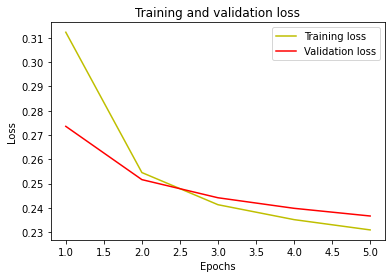

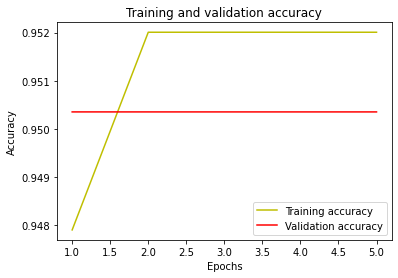

In [21]:
#plotting training and val IoU and loss for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction

In [ ]:
#Set compile to false for only prediction
my_model = load_model('brats_resnet_3d_transfer_learning.hdf5', 
                      compile=False)


#Verify IoU on a batch of images from the test dataset
batch_size=8 
test_img_datagen = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)

#Check the generator
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


img_num = 82
test_img = np.load("./BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("./BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


n_slice = 30
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()